In [ ]:
#| default_exp webdav

# Exploring your remote data in a breeze 

> Instantly find and access all your Nextcloud data files

In order to to make use of `fairdatanow`, you will need a Nextcloud server `url`, a `user` name and a `password` to access a folder on a Nextcloud server. The recommended way to use these credentials in Jupyter notebooks is to store username and password as environment variables on your system. You can retrieve them with the `os.getenv()` function. 

:::{.callout-note} 

In this way you avoid typing them directly in the notebook, which is not save if you need to share these notebooks with others.  

:::

To get started you need to import the `RemoteData` class from the package and instantiate it with the Nextcloud `configuration` dictionary. Depending on the amount of files in the cloud storage it might take some time to build the interactive file table.

 If you know already for which files you are looking, you can provide an optional regular expression search string `search_regex=` as an argument. You can adapt this search string in the interactive table to obtain another filtering.  

In [ ]:
from fairdatanow import RemoteData
import os 

In [ ]:
configuration = {
    'url': "https://laboppad.nl/falnama-project", 
    'user':    os.getenv('NC_AUTH_USER'),
    'password': os.getenv('NC_AUTH_PASS')
}

In [ ]:
remote_data = RemoteData(configuration)

We can now have a look at the contents of the cloud folder using the `RemoteData.listdir()` method. This will create an interactive table with all project files. If we already know better what we are looking for we can shorten the table by providing a regular expression search string `search_regex=` as an optional argument. As an example, let's walk through the process of locating a bunch of xray tif files that the Rijksmuseum created for us. 

In [ ]:
remote_data.listdir(search_regex='xray')

Please wait while scanning all file paths in remote folder...
Ready building file table for 'falnama-project'
Total number of files and directories: 6342
Total size of the files: 194.8 GiB


ITable(classes='display nowrap')

In [ ]:
#|hide
import itables 
from IPython.display import HTML, display


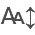

In [ ]:
#|echo: false 

# this cell is needed for the quarto documentation 
display(HTML("<style>.dt-container { font-size: smaller; background-color: white}</style>"))
itables.init_notebook_mode(all_interactive=True)
itables.show(remote_data.df, layout={"top1": "searchBuilder"}, select=True, searchBuilder={}, scrollY="300px", scrollCollapse=True, paging=False, search={'search': 'xray'}) 


If we scroll through this first selection of 209 entries we see that the interactive table contains all kinds of files related to the x-ray images. Using the `Custom Search Builder` and/or adjusting the regular expression in the search bar, we can interactively narrow down the filter to shown only the specific files we currently need. You can try this yourself. 


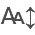

In [ ]:
#|echo: false 

# this cell is needed for the quarto documentation 
display(HTML("<style>.dt-container { font-size: smaller; background-color: white}</style>"))
itables.init_notebook_mode(all_interactive=True)
itables.show(remote_data.df, layout={"top1": "searchBuilder"}, select=True, searchBuilder={}, scrollY="300px", scrollCollapse=True, paging=False, search={'search': 'edited.tif'}) 

It turns out that with `search_regex='edited.tif'` we obtain all 28 tif files that we need for further processing. They contain top halves and bottom halves for 14 pages that were imaged using x-rays.    

We can now select rows by Shift and Ctrl clicking from this interactive table. Rows that are selected will be colored blue. These selected files can then be downloaded with the `.download_selected()` method onto your local machine into a local cache folder. Downloading is skipped if the selected files are already present locally. The local file paths in our cache folder are returned in the `files` list for further processing.   

In [ ]:
files = remote_data.download_selected()

Ready with downloading 28 selected remote files to local cache: /home/frank/.cache/fairdatanow                                                                      /edited pictures/71803-8_bottom_Falnama_grenz_2-2_edited.tif                                                          


Ok, we can now start working with this data to see if we can stitch these halves together. This is the topic of the next section. 

## Using the custom search builder  

In some cases we might need a more powerful filter to precisely select the files that we need. Here is an example of such a predefined search query.  See the DataTables documentation [here](https://datatables.net/reference/type/SearchBuilder.Criteria) for details on the syntax. 

In [ ]:
searchBuilder_rma_zips = {
    "preDefined": {
        "criteria": [
            {"data": "path", "condition": "contains", "value": ["RMA"]}, 
            {"data": "ext", "condition": "=", "value": [".zip"]}
        ]
    }
}

In [ ]:
remote_data.listdir(search_regex='xray', searchBuilder=searchBuilder)

Please wait while scanning all file paths in remote folder...
Ready building file table for 'falnama-project'
Total number of files and directories: 6342
Total size of the files: 194.8 GiB


ITable(classes='display nowrap')


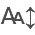

In [ ]:
#|echo: false 

# this cell is needed for the quarto documentation 
display(HTML("<style>.dt-container { font-size: smaller; background-color: white}</style>"))
itables.init_notebook_mode(all_interactive=True)
itables.show(remote_data.df, layout={"top1": "searchBuilder"}, select=True, searchBuilder=searchBuilder_rma_zips, scrollY="300px", scrollCollapse=True, paging=False, search={'search': 'xray'}) 

## FUNCTIONS 

In [ ]:
#| export 

import nc_py_api 
from nc_py_api import Nextcloud 

import humanize
import polars as pl 
import itables
from itables.widget import ITable
import os 
from pathlib import Path 
import time 
import re 
from IPython.display import HTML, display


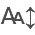

In [ ]:
#|export 

def _node_to_dataframe(fsnode): 
    '''Convert `fsnode` object to polars a single row polars dataframe.'''

    df = pl.DataFrame({'path': fsnode.user_path, 'size': fsnode.info.size, 'mimetype': fsnode.info.mimetype, 'modified': fsnode.info.last_modified, 
                   'isdir': fsnode.is_dir, 'ext': os.path.splitext(fsnode.user_path)[1]})

    return df 

class RemoteData(object): 
    
    # See: https://help.nextcloud.com/t/using-nc-py-api-i-cant-download-any-file-due-to-ssl-certificte-verify-failed/194019 
    nc_py_api.options.NPA_NC_CERT = False 
    
    # keep full dataframe 
    itables.options.maxBytes = 0
    itables.init_notebook_mode()

    def __init__(self, configuration): 
        '''Recursively scan the contents of a remote webdav server as specified by `configuration`. 
        '''

        # parse configuration 
        m = re.match('(^https://[^/]+/)(.*)', configuration['url'])
        nextcloud_url, self.cache_dir = m.groups()
        nc_auth_user = configuration['user']
        nc_auth_pass = configuration['password'] 
               
        # Instantiate Nextcloud client 
        self.nc = Nextcloud(nextcloud_url=nextcloud_url, nc_auth_user=nc_auth_user, nc_auth_pass=nc_auth_pass) 
        

    def listdir(self, subdir=None, search_regex='', searchBuilder={}): 
        '''Create interactive file table for remote subdirectory `subdir`. 

        If subdir is not specified the complete project directory is scanned. 
        '''

        if subdir is None: 
            subdir = self.cache_dir 

        print(f'Please wait while scanning all file paths in remote folder...') 
            
        # query webdav server to obtain file listing 
        fs_nodes_list = self.nc.files.listdir(subdir, depth=-1, exclude_self=False) 
        
        n_paths = len(fs_nodes_list)

        # initialize polars dataframe with first row to fix schema 
        self.df = _node_to_dataframe(fs_nodes_list[0]) 

        # initially moved these lines below because I do not understand 
        # how this could work after only reading the first line 
        # well, perhaps because this is the size that is listed for the directory  
        
        #sum the sizes to find the total storage space
        total_size_bytes = self.df['size'].sum()
        total_size = humanize.naturalsize(total_size_bytes, True)
        
        for fsnode in fs_nodes_list[1:]: 
            self.df.extend(_node_to_dataframe(fsnode)) 

        # create interactive table 
        self.itable = ITable(
                    self.df,
                    layout={"top1": "searchBuilder"},
                    select=True,  
                    search={"regex": True, "caseInsensitive": True, "search": search_regex},  
                    searchBuilder=searchBuilder, 
                    scrollY="500px", scrollCollapse=True, paging=False, 
                ) 

        print(f"Ready building file table for '{self.cache_dir}'")
        print(f'Total number of files and directories: {n_paths}')
        print(f'Total size of the files: {total_size}') 

        return self.itable 
    
    def download_selected(self, cache_dir=None): 
        '''Download selected files (blue rows) from `table` to default local cache directory. 
        
        A custom `cache_dir` can be specified. '''
        
        # create cache path 
        if cache_dir is None: 
            cache_path = Path.home().joinpath('.cache', 'fairdatanow')
        else: 
            cache_path = Path.home().joinpath('.cache', cache_dir)
    
        os.makedirs(cache_path, exist_ok=True)
    
        # obtain remote paths and remote timestamps 
        local_path_list = []
        remote_path_list = [self.itable.df['path'][n] for n in self.itable.selected_rows]
        remote_modified_list = [self.itable.df['modified'][n] for n in self.itable.selected_rows]
        remote_isdir_list = [self.itable.df['isdir'][n] for n in self.itable.selected_rows]
        
        n_files = len(remote_path_list)
       
        for i, [remote_path, remote_modified, remote_isdir] in enumerate(zip(remote_path_list, remote_modified_list, remote_isdir_list)): 
    
            # only download actual files 
            if not remote_isdir:   
                remote_directory = os.path.dirname(remote_path)
                local_directory = cache_path.joinpath(remote_directory) # I guess this will not yet work for Windows
                
                # create directory structure inside cache 
                os.makedirs(local_directory, exist_ok=True) 
            
                # get remote epoch time  
                remote_modified_epoch_time = remote_modified.timestamp()
            
                # construct corresponding local path 
                local_path = cache_path.joinpath(remote_path) 
                local_path_list.append(str(local_path))
                
            
                # check if local file exists and if modification times are similar 
                is_local = local_path.exists()  
            
                is_similar = False 
                local_modified_epoch_time = None 
                if is_local: 
                    local_modified_epoch_time = os.stat(local_path).st_mtime
                    if local_modified_epoch_time == remote_modified_epoch_time: 
                        is_similar = True 
                        
                # download from nextcloud 
                if not is_similar: 
                    print(f'[{i}/{n_files - 1}] Timestamps do no match: {remote_modified_epoch_time} vs {local_modified_epoch_time}', end='\r')
                    print(f'[{i}/{n_files - 1}] Downloading to: {local_path}                                                       ' , end='\r')
                      
                    # write to cache 
                    with open(local_path, 'bw') as fh: 
                        self.nc.files.download2stream(remote_path, fh) 
                        
                    # adjust last modified timestamp 
                    now = int(time.time())
                    os.utime(local_path, (now, remote_modified_epoch_time)) 
                    
        print(f"Ready with downloading {n_files} selected remote files to local cache: {cache_path}                                                                      ")

        return local_path_list

    def download(self, remote_path, local_path, chunk_size='5Mb'):
        #TODO: refactor download to this function
        return

    def upload(self, remote_path, local_path, allow_edit=False, chunk_size='5Mb'):
        '''Uploads a local file to the remote nextcloud storage. Use allow_edit to be able to override an existing file.'''

        # check if user is overriding file information and if it's allowed
        if (self.check_exist(remote_path)) and (not allow_edit):
            print(f"There is already a file present at {remote_path}, allow overrides with allow_edit=True")
            return

        # get file size in bytes and make it human readable
        file_size_bytes = os.path.getsize(local_path)
        file_size = humanize.naturalsize(file_size_bytes, True)
        
        write = input(f"File size is {file_size} \nDo you want to continue the upload to {remote_path} [y/n]?.")

        if write != 'y':
            print("Upload aborted.")
            return
            
        print(f"Starting upload to {remote_path}.")
        
        with open(local_path, 'br') as fp:
            self.nc.files.upload_stream(remote_path, fp)

        # search for the newly created fsnode and add to the dataframe
        remote_dir, remote_file = os.path.split(remote_path)
        fsnode = self.nc.files.find(['eq', 'name', remote_file], remote_dir)[0]
        
        self.df.extend(_node_to_dataframe(fsnode))
        self._reload_itable()
        
        print(f"Upload finished.")
        
        
    
    def delete(self, remote_path):
        '''Delete a file in the remote Nextcloud storage.'''

        #TODO: Check if remote_path is an empty dir.
        
        write = input(f"Are you sure you want to delete {remote_path} [y/n]?")
        if write != 'y':
            print("Deletion aborted.")
            return
            
        # search for the newly created fsnode and delete from the dataframe
        remote_dir, remote_file = os.path.split(remote_path)
        fsnode = self.nc.files.find(['eq', 'name', remote_file], remote_dir)[0]
        
        self.nc.files.delete(remote_path)
    
        self.df = self.df.filter(pl.col("path") != fsnode.user_path)
        self._reload_itable()

        print("File removed.")

    def check_exist(self, remote_path):
        '''Checks the dataframe to see if the given path is already present.'''

        # checks the path column and looks for any similarities with the remote_path
        result = self.df['path'].is_in([remote_path]).any()
        
        return result

    def _reload_itable(self):
        '''Reloads the dataframe stored in the itable object'''
        self.itable.df = self.df




